Questions

- Examine randomcrop in tf vs fastai
- How many layers can I add to increase complexity?

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import os
import PIL
import PIL.Image

from collections import Counter
import pathlib

print("TensorFlow Versions: ", tf.__version__)
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


TensorFlow Versions:  2.7.0
TensorFlow **IS** using the GPU


In [2]:
batch_size = 32
img_height = 160
img_width = 160
seed = 120

epochs = 10

data_dir = pathlib.Path('/home/addy/.keras/datasets/pets_photos')

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  # image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  # image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

Found 7390 files belonging to 2 classes.
Using 5912 files for training.
Found 7390 files belonging to 2 classes.
Using 1478 files for validation.


2021-12-30 23:13:52.321272: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-30 23:13:52.717546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4227 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
resize_and_augment = tf.keras.Sequential(
  [
    tf.keras.layers.RandomCrop(img_width, img_height),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)


2021-12-30 23:13:57.234070: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


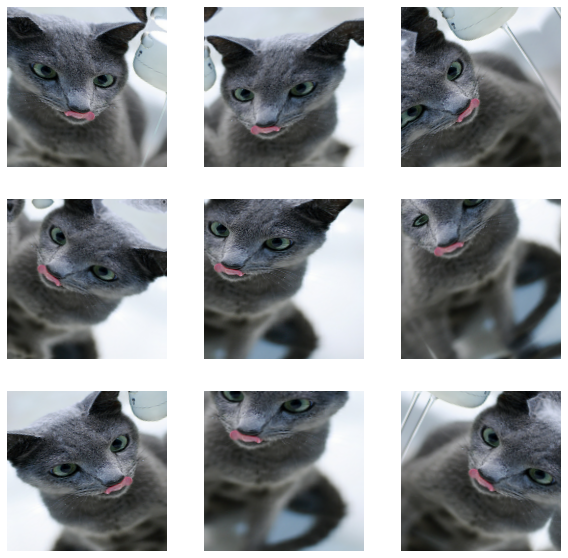

In [6]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_image = resize_and_augment(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")


In [11]:
num_classes = 1
model = tf.keras.Sequential([
  resize_and_augment,
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [14]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
185/185 [==============================] - 6s 27ms/step - loss: 0.5549 - binary_accuracy: 0.7202 - val_loss: 0.6745 - val_binary_accuracy: 0.6042
Epoch 2/20
185/185 [==============================] - 5s 26ms/step - loss: 0.5393 - binary_accuracy: 0.7283 - val_loss: 0.5892 - val_binary_accuracy: 0.7321
Epoch 3/20
185/185 [==============================] - 5s 26ms/step - loss: 0.5381 - binary_accuracy: 0.7309 - val_loss: 0.5982 - val_binary_accuracy: 0.6976
Epoch 4/20
185/185 [==============================] - 5s 26ms/step - loss: 0.5229 - binary_accuracy: 0.7419 - val_loss: 0.5148 - val_binary_accuracy: 0.7632
Epoch 5/20
185/185 [==============================] - 5s 25ms/step - loss: 0.5253 - binary_accuracy: 0.7393 - val_loss: 0.6622 - val_binary_accuracy: 0.7341
Epoch 6/20
185/185 [==============================] - 5s 25ms/step - loss: 0.5139 - binary_accuracy: 0.7542 - val_loss: 0.5143 - val_binary_accuracy: 0.74707 - bi
Epoch 7/20
185/185 [==============================] 

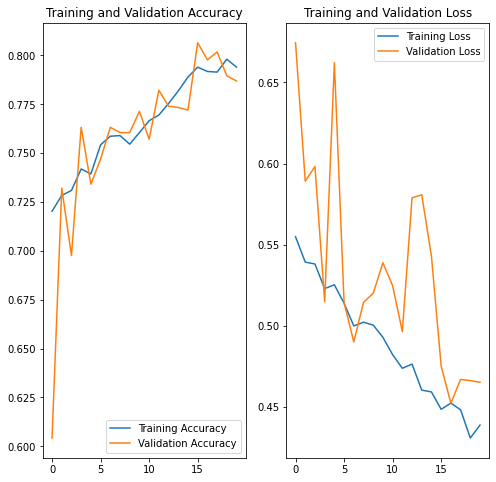

In [15]:
def plotTrainingGraphs(history, epochs):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


plotTrainingGraphs(history, 20)

